## Getting data by area and fitting Random forest model

The present notebook:

   - loads the data provided by the user selected by area.
   - merges it with E.coli data
   - trains a Random Forest model after grid search of hyperparameters
   - Visualizes results in interactive plotly image

In [407]:
from ews.models import BathingSpot
from django_pandas.io import read_frame
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from shapely.geometry import shape, Point
import plotly.express as px
import statsmodels


In [408]:
model = PredictionModel.objects.get(name = "24-features-RF-model")

In [409]:
PredictionModel.objects.all()

<QuerySet [<PredictionModel: 24-features-RF-model>]>

In [410]:
PredictionModel.objects.all()

<QuerySet [<PredictionModel: 24-features-RF-model>]>

In [411]:
areas = read_frame(model.area.all())

In [412]:
areas

,id,name,geom,feature_type
0,21,Rain I,"{'type': 'Polygon', 'coordinates': [[[2.305902...",Rainfall
1,22,Rain II,"{'type': 'Polygon', 'coordinates': [[[2.28048,...",Rainfall
2,23,Rain III,"{'type': 'Polygon', 'coordinates': [[[2.338194...",Rainfall
3,24,Rain IV,"{'type': 'Polygon', 'coordinates': [[[2.386288...",Rainfall
4,25,Rain V,"{'type': 'Polygon', 'coordinates': [[[2.431634...",Rainfall
5,26,WWTP Marne,"{'type': 'Polygon', 'coordinates': [[[2.490764...",WWTP
6,27,WWTP Seine,"{'type': 'Polygon', 'coordinates': [[[2.389723...",WWTP
7,28,Flow center,"{'type': 'Polygon', 'coordinates': [[[2.339568...",Riverflow
8,29,Flow Marne,"{'type': 'Polygon', 'coordinates': [[[2.450096...",Riverflow
9,30,Flow Seine,"{'type': 'Polygon', 'coordinates': [[[2.381478...",Riverflow


In [413]:
areavars = []
for index1, row1 in areas.iterrows():
    df = read_frame(Site.objects.filter(feature_type = FeatureType.objects.get(name=row1["feature_type"])))
    polygon = shape(row1["geom"])
    select = []
    
    for index2, row2 in df.iterrows():
        select.append(polygon.contains(shape(row2['geom'])))
    data = read_frame(FeatureData.objects.filter(site__in = df[select]['id']), index_col = "date")
    data["area"] = row1["name"]
    data["feature_type"] = row1["feature_type"]
    areavars.append(data)

In [414]:
areavars

[                               id  value    site variable    area feature_type
 date                                                                          
 2016-01-01 00:00:00+00:00  289486  0.240  Lhay35     None  Rain I     Rainfall
 2016-01-02 00:00:00+00:00  289487  0.240  Lhay35     None  Rain I     Rainfall
 2016-01-03 00:00:00+00:00  289488  1.880  Lhay35     None  Rain I     Rainfall
 2016-01-04 00:00:00+00:00  289489  0.040  Lhay35     None  Rain I     Rainfall
 2016-01-05 00:00:00+00:00  289490  0.240  Lhay35     None  Rain I     Rainfall
 ...                           ...    ...     ...      ...     ...          ...
 2019-12-27 00:00:00+00:00  299708  0.840  Vitr02     None  Rain I     Rainfall
 2019-12-28 00:00:00+00:00  299709  0.000  Vitr02     None  Rain I     Rainfall
 2019-12-29 00:00:00+00:00  299710  0.040  Vitr02     None  Rain I     Rainfall
 2019-12-30 00:00:00+00:00  299711  0.000  Vitr02     None  Rain I     Rainfall
 2019-12-31 00:00:00+00:00  299712  0.04

In [417]:
lagvars = []

for i in range(len(areavars)):
    ft = areavars[i].area.unique()+ " " +areavars[i].feature_type.unique()
    d = areavars[i].pivot(columns = 'site', values = 'value')
    if len(d.columns) > 1:
        d = pd.DataFrame(d.mean(axis = 1, skipna = True))
    for j in [1, 2, 3, 4, 5]:
        df = pd.DataFrame()
        df[ft + '_shift_'+ str(j)] = d.rolling(window=j).mean().shift(1)
        lagvars.append(df)
        
res = pd.concat(lagvars, axis = 1)

<AxesSubplot:xlabel='date'>

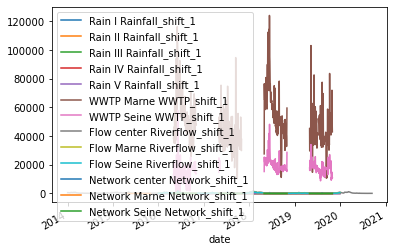

In [418]:
res.filter(regex='_shift_1').plot()

In [419]:
res.describe()

,Rain I Rainfall_shift_1,Rain I Rainfall_shift_2,Rain I Rainfall_shift_3,Rain I Rainfall_shift_4,Rain I Rainfall_shift_5,Rain II Rainfall_shift_1,Rain II Rainfall_shift_2,Rain II Rainfall_shift_3,Rain II Rainfall_shift_4,Rain II Rainfall_shift_5,...,Network Marne Network_shift_1,Network Marne Network_shift_2,Network Marne Network_shift_3,Network Marne Network_shift_4,Network Marne Network_shift_5,Network Seine Network_shift_1,Network Seine Network_shift_2,Network Seine Network_shift_3,Network Seine Network_shift_4,Network Seine Network_shift_5
count,1460.000000,1.459000e+03,1.458000e+03,1457.000000,1.456000e+03,913.000000,912.000000,911.000000,910.000000,909.000000,...,919.000000,918.000000,917.000000,916.000000,915.000000,733.000000,732.000000,731.000000,730.000000,729.000000
mean,0.364123,3.642838e-01,3.644490e-01,0.364314,3.641566e-01,1.120482,1.121628,1.122832,1.121676,1.120770,...,0.014636,0.014576,0.014553,0.014513,0.014479,0.098672,0.098807,0.098942,0.099077,0.099199
std,1.034241,8.278552e-01,7.183477e-01,0.655465,6.105645e-01,3.202082,2.545854,2.155692,1.921675,1.758323,...,0.046439,0.038191,0.033634,0.030761,0.028648,0.493911,0.450677,0.421201,0.399659,0.380002
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000714,0.000727,0.000727,0.000727,0.000727,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,2.960595e-16,0.000000,5.329071e-16,0.000000,0.000000,0.000000,0.000000,0.020000,...,0.002050,0.002200,0.002233,0.002325,0.002429,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.387779e-17,2.666667e-02,0.060000,8.200000e-02,0.000000,0.075000,0.200000,0.312500,0.370000,...,0.002650,0.003558,0.004963,0.005200,0.005240,0.000000,0.000000,0.008965,0.013158,0.013764
75%,0.180000,3.600000e-01,4.266667e-01,0.470000,5.360000e-01,0.600000,1.006250,1.325000,1.550000,1.560000,...,0.005800,0.008000,0.010683,0.012650,0.013022,0.017579,0.026316,0.030303,0.039059,0.036364
max,14.640000,8.560000e+00,5.893333e+00,4.850000,4.240000e+00,44.050000,32.625000,21.933333,16.537500,13.810000,...,0.615750,0.600275,0.421755,0.384745,0.317110,7.666500,6.999750,5.999833,5.499875,4.599900


In [420]:
res = res[res.index.month.isin([5, 6, 7, 8, 9])].reset_index()

In [421]:
rain_cols = [col for col in res.columns if 'Rainfall' in col]

In [422]:
res[rain_cols] = res[rain_cols].add(1).apply(np.log)

In [425]:
np.log10(500)

2.6989700043360187

In [344]:
FIB = read_frame(FeatureData.objects.filter(site = model.site.all()[0]))

In [345]:
FIB["date"] = FIB.date.round("D")

In [346]:
FIB.describe()

,id
count,789.000000
mean,300752.000000
std,227.908973
min,300358.000000
25%,300555.000000
50%,300752.000000
75%,300949.000000
max,301146.000000


In [347]:
d = FIB.merge(res, on= "date").drop("variable", axis = 1)

In [348]:
D = d.dropna()

In [349]:
D.describe()

,id,Rain I_shift_1,Rain I_shift_2,Rain I_shift_3,Rain I_shift_4,Rain I_shift_5,Rain II_shift_1,Rain II_shift_2,Rain II_shift_3,Rain II_shift_4,...,Network Marne_shift_1,Network Marne_shift_2,Network Marne_shift_3,Network Marne_shift_4,Network Marne_shift_5,Network Seine_shift_1,Network Seine_shift_2,Network Seine_shift_3,Network Seine_shift_4,Network Seine_shift_5
count,390.000000,390.000000,390.000000,3.900000e+02,390.000000,3.900000e+02,390.000000,390.000000,390.000000,390.000000,...,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,300775.458974,0.080788,0.095661,1.080514e-01,0.107864,1.116933e-01,0.187412,0.221782,0.255530,0.277769,...,0.008686,0.007802,0.007761,0.007550,0.007813,0.020344,0.019278,0.019030,0.018439,0.018828
std,219.633797,0.283999,0.258817,2.480522e-01,0.230544,2.199214e-01,0.530007,0.506625,0.485764,0.466189,...,0.030018,0.021650,0.017841,0.015192,0.014114,0.064312,0.054436,0.048092,0.042043,0.039690
min,300458.000000,0.000000,0.000000,0.000000e+00,0.000000,2.220446e-16,0.000000,0.000000,0.000000,0.000000,...,0.000727,0.000727,0.000727,0.000727,0.000727,0.000000,0.000000,0.000000,0.000000,0.000000
25%,300555.250000,0.000000,0.000000,0.000000e+00,0.000000,4.440892e-16,0.000000,0.000000,0.000000,0.000000,...,0.001090,0.001166,0.001283,0.001397,0.001481,0.000000,0.000000,0.000000,0.000000,0.000000
50%,300796.500000,0.000000,0.000000,2.220446e-16,0.000000,4.440892e-16,0.000000,0.000000,0.000000,0.054707,...,0.001476,0.001726,0.002077,0.002360,0.002467,0.003310,0.007420,0.008916,0.009787,0.010471
75%,300995.750000,0.000000,0.000000,3.278982e-02,0.076961,1.663518e-01,0.000000,0.139762,0.324496,0.378001,...,0.002361,0.004170,0.005726,0.007496,0.007641,0.014344,0.019177,0.017474,0.017190,0.019859
max,301097.000000,2.230014,1.958685,1.675226e+00,1.526056,1.355835e+00,3.258097,3.107944,2.744061,2.482821,...,0.286907,0.200325,0.149770,0.119360,0.099402,0.554067,0.488241,0.407638,0.343030,0.293086


In [350]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 559 entries, 0 to 558
Data columns (total 69 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   id                      559 non-null    int64              
 1   date                    559 non-null    datetime64[ns, UTC]
 2   value                   559 non-null    object             
 3   site                    559 non-null    object             
 4   Rain I_shift_1          559 non-null    float64            
 5   Rain I_shift_2          559 non-null    float64            
 6   Rain I_shift_3          559 non-null    float64            
 7   Rain I_shift_4          559 non-null    float64            
 8   Rain I_shift_5          559 non-null    float64            
 9   Rain II_shift_1         543 non-null    float64            
 10  Rain II_shift_2         543 non-null    float64            
 11  Rain II_shift_3         543 non-null    float

In [351]:
y = np.log10(D["value"])

In [352]:
X = D.drop(["date", "value", "id", "site"], axis = 1)

In [353]:
X = X.apply(pd.to_numeric, downcast='float')

In [354]:
y = y.apply(pd.to_numeric, downcast='float')

In [355]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)


In [356]:
grid = {'n_estimators':[100], 'max_depth': np.linspace(1, 15, 6), 'max_features': [2, 4, 6],  'min_samples_leaf':[1]} 


In [357]:
import numpy as np
from sklearn.metrics import make_scorer

def my_custom_loss_func(y_true, y_pred):
    diff = np.abs(y_true - y_pred).max()
    return diff

# score will negate the return value of my_custom_loss_func,
# which will be np.log(2), 0.693, given the values for X
# and y defined below.
score = make_scorer(my_custom_loss_func, greater_is_better=True)

In [285]:

from sklearn.model_selection import GridSearchCV, train_test_split


# Instantiate the ElasticNet regressor: elastic_net
rf = RandomForestRegressor()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(rf, param_grid=grid,  cv = 5)

# Fit it to the training data

gm_cv.fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators = gm_cv.best_params_["n_estimators"],
                           max_depth = gm_cv.best_params_["max_depth"],
                           max_features = gm_cv.best_params_["max_features"])
rf.fit(X_train, y_train)


# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
y_pred1 = rf.predict(X_test)


r2 = gm_cv.score(X_test, y_test)
r2_in = gm_cv.score(X_train, y_train)

mse = mean_squared_error(y_test, y_pred)
mse_in = mean_squared_error(y_train, gm_cv.predict(X_train))

print(str("OUT OF SAMPLE METRICS:"))
print("Tuned  RandomForest R squared: {}".format(r2))
print("Tuned RandomForestt MSE: {}".format(mse))
print('---------------------------')
print("IN SAMPLE METRICS:")
print("Tuned  RandomForest R squared: {}".format(r2_in))
print("Tuned RandomForestt MSE: {}".format(mse_in))



OUT OF SAMPLE METRICS:
Tuned  RandomForest R squared: 0.2947032634746918
Tuned RandomForestt MSE: 0.2365332661029718
---------------------------
IN SAMPLE METRICS:
Tuned  RandomForest R squared: 0.7349533450582211
Tuned RandomForestt MSE: 0.09848072965780284


In [358]:
rf = RandomForestRegressor(n_estimators = 1000, min_samples_leaf = 1)

In [359]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

In [360]:
rf.score(X_train, y_train)

0.7957485406055833

In [361]:
rf.score(X_test, y_test)

0.2518332625006656

In [362]:
pred = rf.predict(X_test)

In [363]:
mean_squared_error(pred, y_test)

0.2509104506596171

In [364]:
preds = []
for i in range(1000):
    preds.append(rf.estimators_[i].predict(X_test))

el_arrays = []
for j in range(len(y_test)):
    el_arrays.append([item[j] for item in preds])

In [365]:
lower = []
upper = []
for i in range(len(el_arrays)):
    lower.append(np.percentile(el_arrays[i], 5))
    upper.append(np.percentile(el_arrays[i], 95))

In [366]:
np.log10(500)

2.6989700043360187

In [367]:
df = pd.DataFrame({"y_test":y_test, "mean":pred, "P95": upper, "P5": lower})

In [368]:
comparison_column = np.where(df["y_test"] < df["P95"], True, False)

In [369]:
np.mean(comparison_column)

0.8589743589743589

In [370]:
df["sample_number"] = np.linspace(1, len(y_test), len(y_test))

In [371]:
predictions = df.melt(id_vars=['sample_number'], value_vars=['y_test', 'P5', 'mean', 'P95'])

In [372]:
df

,y_test,mean,P95,P5,sample_number
290,3.643946,4.056964,4.544068,2.701777,1.0
510,3.000434,3.298841,4.223755,2.833400,2.0
227,2.594393,2.777889,2.938019,2.682145,3.0
147,4.544068,3.337799,4.374217,2.586587,4.0
506,2.488551,2.448390,3.326131,2.225309,5.0
...,...,...,...,...,...
545,3.264109,2.960959,3.256237,2.744293,74.0
217,2.403121,3.129941,4.544068,2.328380,75.0
541,2.674861,2.699842,3.516991,2.287802,76.0
189,2.843233,3.624452,4.101506,2.747412,77.0


In [373]:
import plotly.graph_objects as go

upper_bound = go.Scatter(name="Oberes Vorhersageintervall",
x= df["sample_number"],
y = df["P95"],
mode="lines",
line=dict(width=0.5, color="rgba(68, 68, 68, 1)"),
fillcolor="rgba(68, 68, 68, 1)")#, fill="tonexty")

mean = go.Scatter(name="Vorhergesagter Mittelwert",
x= df["sample_number"],
y=df["mean"],
marker = dict(color = "rgb(0, 86, 110)"),
mode="lines",
line=dict(width=2, color= "rgb(0, 86, 110)"),
fillcolor="rgba(68, 68, 68, 0.1)")#, fill="tonexty")

measurements = go.Scatter(name="Vorhergesagter Mittelwert",
x= df["sample_number"],
y=df["y_test"],
marker = dict(color = "orange", size = 8, opacity = .8),
mode="markers",
line=dict(width=2, color= "red"),
fillcolor="rgba(68, 68, 68, 0.1)")#, fill="tonexty")



lower_bound = go.Scatter(name="Unteres Vorhersageintervall",
x=df["sample_number"],
y=df["P5"],
mode="lines",
line=dict(width=0.5, color="rgba(68, 68, 68, 1)"))

data = [lower_bound, mean, upper_bound, measurements]

layout=go.Layout(title='Vorhergesagte E.coli Konzentration seit Beginn der Badesaison 2020',
yaxis=dict(title="E.coli lg [MPN/100ML), showlegend = True"))

fig=go.Figure(data=data, layout = layout)
#fig.update_layout(legend=dict(
#    yanchor="top",
#    title=None,
#    y=0.99,
#    xanchor="left",
#    x=0.01
#))

fig.show()

In [374]:
px.histogram(x = y_test-pred)

In [375]:
np.sqrt(np.mean((y_test-pred)**2))

0.500909623245169

In [376]:
np.std(y_test-pred)

0.4875475724800684

In [377]:
df_test = pd.DataFrame({'meas': y_test, 'pred': rf.predict(X_test), 'split': 'out of sample'})
df_train = pd.DataFrame({'meas': y_train, 'pred': rf.predict(X_train), 'split': 'in sample'})
df = pd.concat([df_test, df_train])
                        


In [378]:
fig = px.scatter(df, x = "meas", y = "pred", color = "split", 
                 color_discrete_sequence=['#212c52','#75c3ff'])

fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Model fit of Random Forest model'},
    xaxis_title = "measured data (sample)",
    yaxis_title = "fitted values (in sample fit)",
    #markersize= 12,
  )
fig.update_layout(legend=dict(
    yanchor="top",
    title=None,
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.update_traces(marker_size = 10)

#['#75c3ff', "red"],#, marker_line_color='#212c52',
 #                 marker_line_width=1.5, opacity=1)



In [379]:
fig.show()

In [202]:
importances = pd.Series(data=rf.feature_importances_,
                        index= X.columns)

# Sort importances
importances_sorted = importances.sort_values()
importances_df = importances_sorted.reset_index()
importances_df.columns = ["feature", "importance"]

In [203]:
# Draw a horizontal barplot of importances_sorted
import plotly.express as px


fig = px.bar(importances_df, y="feature", x="importance", orientation='h'    )

fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Feature importance of Random Forest model'}
    #markercolor = "#212c52"
  
)
fig.update_traces(marker_color='#75c3ff', marker_line_color='#75c3ff',
                  marker_line_width=1.5, opacity=1)

fig.show()


# AdaBoost

In [204]:
from sklearn.ensemble import AdaBoostRegressor

In [205]:
ada = AdaBoostRegressor(n_estimators=10000)

In [206]:
ada.fit(X_train, y_train)

AdaBoostRegressor(n_estimators=10000)

In [207]:
ada.score(X_train, y_train)

0.4062334633007445

In [208]:
y_pred = ada.predict(X_test)

In [209]:
ada.score(X_test, y_test)

0.12597199442058238

In [210]:
fig = px.scatter(x = y_test, y = y_pred)

fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Model fit of Random Forest model'},
    xaxis_title = "measured data (sample)",
    yaxis_title = "fitted values (in sample fit)",
    #markersize= 12,
  )
fig.update_layout(legend=dict(
    yanchor="top",
    title=None,
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.update_traces(marker_size = 10)

In [211]:
fig.show()

## Calculating prediction intervals

In [380]:
from sklearn.ensemble import GradientBoostingRegressor# Set lower and upper quantile

LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95# Each model has to be separate

lower_model = GradientBoostingRegressor(loss="quantile",                   
                                        alpha=LOWER_ALPHA)
# The mid model will use the default loss
mid_model = GradientBoostingRegressor(loss="ls")

upper_model = GradientBoostingRegressor(loss="quantile",
                                        alpha=UPPER_ALPHA)

In [388]:
import scipy.stats
import decimal

weights = scipy.stats.norm(3, .7).pdf(y_train.apply(float))

In [389]:
px.scatter(x = y_train, y = weights)

In [390]:
# Fit models
lower_model.fit(X_train, y_train, sample_weight =weights)
mid_model.fit(X_train, y_train, sample_weight =weights)
upper_model.fit(X_train, y_train, sample_weight =weights)# Record actual values on test set

predictions = pd.DataFrame(y_test)# Predict

predictions['lower'] = lower_model.predict(X_test)
predictions['mid'] = mid_model.predict(X_test)
predictions['upper'] = upper_model.predict(X_test)

In [391]:
predictions["Nummer"] = range(len(predictions))

In [392]:
import plotly.graph_objects as go

upper_bound = go.Scatter(name="Oberes Vorhersageintervall",
x= predictions["Nummer"],
y=predictions["upper"],
mode="lines",
line=dict(width=0.5, color="rgba(68, 68, 68, 1)"),
fillcolor="rgba(68, 68, 68, 1)")#, fill="tonexty")

mean = go.Scatter(name="Vorhergesagter Mittelwert",
x= predictions["Nummer"],
y=predictions["mid"],
marker = dict(color = "rgb(0, 86, 110)"),
mode="lines",
line=dict(width=2, color= "rgb(0, 86, 110)"),
fillcolor="rgba(68, 68, 68, 0.1)")#, fill="tonexty")

measurements = go.Scatter(name="Vorhergesagter Mittelwert",
x= predictions["Nummer"],
y=predictions["value"],
marker = dict(color = "orange", size = 8, opacity = .8),
mode="markers",
line=dict(width=2, color= "red"),
fillcolor="rgba(68, 68, 68, 0.1)")#, fill="tonexty")



lower_bound = go.Scatter(name="Unteres Vorhersageintervall",
x= predictions["Nummer"],
y=predictions["lower"],
mode="lines",
line=dict(width=0.5, color="rgba(68, 68, 68, 1)"))

data = [lower_bound, mean, upper_bound, measurements]

layout=go.Layout(title='Vorhergesagte E.coli Konzentration seit Beginn der Badesaison 2020',
yaxis=dict(title="E.coli lg [MPN/100ML), showlegend = True"))

fig=go.Figure(data=data, layout = layout)
#fig.update_layout(legend=dict(
#    yanchor="top",
#    title=None,
#    y=0.99,
#    xanchor="left",
#    x=0.01
#))

fig.show()
    

In [393]:
fig = px.scatter(predictions, x = "value", y = "mid", 
                 color_discrete_sequence=['#212c52'], trendline = 'OLS')

fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Model fit of Random Forest model'},
    xaxis_title = "measured data (sample)",
    yaxis_title = "fitted values (in sample fit)",
    #markersize= 12,
  )
fig.update_layout(legend=dict(
    yanchor="top",
    title=None,
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.update_traces(marker_size = 10)#['#75c3ff', "red"],#, marker_line_color='#212c52',
 #                 marker_line_width=1.5, opacity=1)

fig.show()

In [394]:


import numpy as np
import pandas as pd
from sklearn.datasets import make_regression

from matplotlib import pyplot as plt
%matplotlib inline

from bartpy.sklearnmodel import SklearnModel



In [395]:
def get_clean_model():
    return SklearnModel(n_chains=4, 
                        n_jobs= 4, 
                        n_burn=200,
                        n_samples=1000, 
                        n_trees=200, 
                        initializer=None)



In [396]:
model = get_clean_model()



In [397]:
bart = model.fit(X_train, y_train)

In [400]:
bart.score(X_test, y_test)

0.27379552008100017

In [398]:
fig = px.scatter(y = bart.predict(X_test), x = y_test, 
           color_discrete_sequence=['#212c52','light grey', '#75c3ff','light grey'])
fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Model fit of Random Forest model'},
    xaxis_title = "measured data (sample)",
    yaxis_title = "ground truth and predicted",
    #markersize= 12,
  )
fig.update_layout(legend=dict(
    yanchor="top",
    title=None,
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.update_traces(marker_size = 10)

In [206]:
predicitons = bart.predict(X_test)

In [207]:
dir(bart)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_acceptance_trace',
 '_check_n_features',
 '_combine_chains',
 '_construct_model',
 '_convert_covariates_to_data',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_model_samples',
 '_more_tags',
 '_out_of_sample_predict',
 '_prediction_samples',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'acceptance_trace',
 'alpha',
 'beta',
 'columns',
 'combined_chains',
 'data',
 'extract',
 'f_chains',
 'f_delayed_chains',
 'fit',
 'fit_predict',
 'from_extract',
 'get_params',
 'initializer',
 'l2_error',
 'model',
 'model_samples',
 'n_burn',
 'n_chains

NameError: name 'bart' is not defined